Proviamo a prendere le linee laterali della pista

In [1]:
import cv2
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd


Load video

In [2]:
# Define the relative path to the video file
notebook_dir = Path().resolve()
project_root = notebook_dir.parent.parent
video_path = project_root / "data" / "recording_2" / "Recording_2_normal_speed.mp4"
video_path = str(video_path)

# Load the video
cap = cv2.VideoCapture(video_path)

# Check
print(f"Opened: {cap.isOpened()}, FPS: {cap.get(cv2.CAP_PROP_FPS)}, Total Frames: {cap.get(cv2.CAP_PROP_FRAME_COUNT)}")

Opened: True, FPS: 59.94005994005994, Total Frames: 276.0


Get frame

In [3]:
# Set frame position
cap.set(cv2.CAP_PROP_POS_FRAMES, 255)
ret, image_color = cap.read()
if not ret:
    print("Failed to read the frame")
    cap.release()
    exit()

Import base line

In [4]:
# Define the relative path to the CSV file
input_path = project_root / "notebook" / "lane_detection" / "intermediate_data" / "horizontal_line_2.csv"
input_path = str(input_path)

# Load the CSV file into a DataFrame
df = pd.read_csv(input_path)

# Display the first few rows of the DataFrame
print(df.head())

# Extract the rho and theta coordinates of the horizontal line
rho = df.loc[0, "rho"]
theta = df.loc[0, "theta"]

# define the horizontal line
horizontal_line = [rho, theta]

      rho     theta
0  1054.0  1.570796


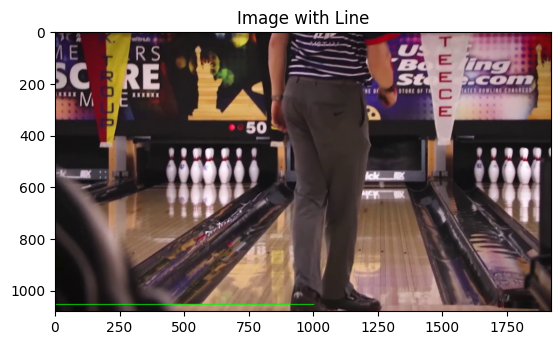

In [5]:
# Convert polar coordinates to Cartesian coordinates for the line
a = np.cos(theta)
b = np.sin(theta)
x0 = a * rho
y0 = b * rho
x1 = int(x0 + 1000 * (-b))
y1 = int(y0 + 1000 * (a))
x2 = int(x0 - 1000 * (-b))
y2 = int(y0 - 1000 * (a))

# Draw the line on the image
image_with_line = image_color.copy()
cv2.line(image_with_line, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the image
plt.imshow(cv2.cvtColor(image_with_line, cv2.COLOR_BGR2RGB))
plt.title("Image with Line")
plt.show()

Select the central point in the line

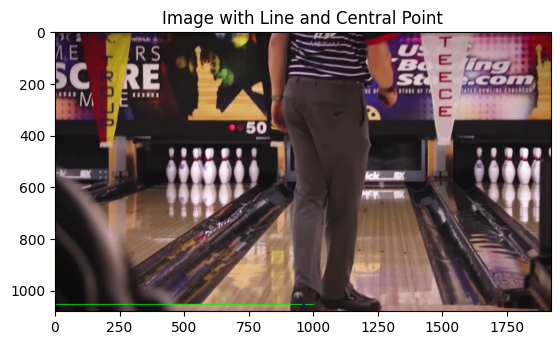

In [6]:
# Get the x-size of the image
x_size = image_color.shape[1]

# Calculate the x-coordinate that is half of the x-size
x_half = x_size // 2

# Calculate the corresponding y-coordinate using the line equation
y_half = int((rho - x_half * a) / b)

# Draw the point on the image
image_with_point = image_with_line.copy()
cv2.circle(image_with_point, (x_half, y_half), 5, (255, 0, 0), -1)

# Display the image
plt.imshow(cv2.cvtColor(image_with_point, cv2.COLOR_BGR2RGB))
plt.title("Image with Line and Central Point")
plt.show()

Ricava gli edges dall'immagine brown-rose

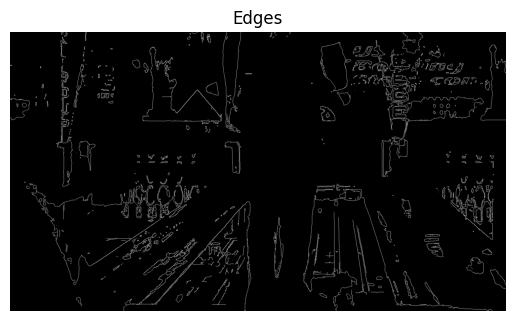

In [7]:
# Define the range for light brown color in HSV
lower_brown = np.array([00, 30, 100])
upper_brown = np.array([20, 200, 255])

# Define the range for rose color in HSV
lower_rose = np.array([150, 30, 200])
upper_rose = np.array([180, 200, 255])

# Convert the image to HSV color space
hsv_image = cv2.cvtColor(image_color, cv2.COLOR_BGR2HSV)

# Create masks for brown and rose colors
mask_brown = cv2.inRange(hsv_image, lower_brown, upper_brown)
mask_rose = cv2.inRange(hsv_image, lower_rose, upper_rose)

# Combine the masks
combined_mask = cv2.bitwise_or(mask_brown, mask_rose)

# apply brown and rose mask
extracted_image = cv2.bitwise_and(image_color, image_color, mask=combined_mask)

# Convert the bottom image to grayscale
gray_image = cv2.cvtColor(extracted_image, cv2.COLOR_BGR2GRAY)

# Compute Otsu's threshold 
otsu_thresh, _ = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Set lower and upper thresholds relative to Otsu's threshold
lower = 0.5 * otsu_thresh
upper = 1.5 * otsu_thresh

# get edges
edges = cv2.Canny(gray_image, lower, upper)

# Show the edges
plt.imshow(edges, cmap='gray')
plt.title("Edges")
plt.axis('off')
plt.show()

Get lines

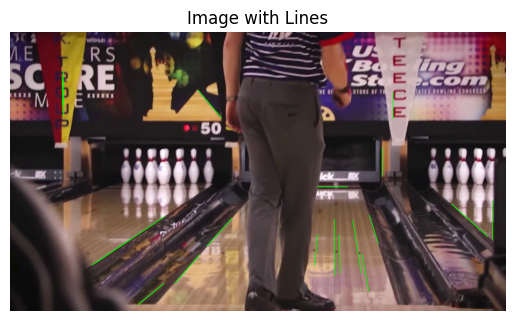

In [11]:
# Apply Probabilistic Hough Line Transform (allow to set minLineLength and maxLineGap)
min_line_length = 100
max_line_gap = 10 
lines_p = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength=min_line_length, maxLineGap=max_line_gap) 

# Draw the lines on the image
image_with_lines = np.copy(image_color)
if lines_p is not None:
    for line in lines_p:
        x1, y1, x2, y2 = line[0]
        cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Show the image with lines
plt.imshow(cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB))
plt.title("Image with Lines")
plt.axis('off')
plt.show()

Prendo la linea più vicina al mio punto \
prima elimino le linee quasi orizzontali

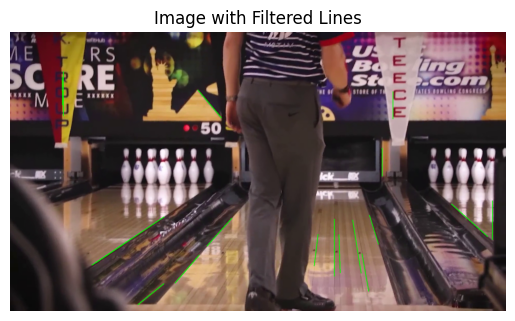

In [12]:
# Function to calculate the angle of a line
def calculate_angle(x1, y1, x2, y2):
    return abs(math.degrees(math.atan2(y2 - y1, x2 - x1)))

# Filter out lines that are 'quite horizontal' with a tolerance of 20 degrees
non_horizontal_lines = []
tolerance = 20
for line in lines_p:
    x1, y1, x2, y2 = line[0]
    angle = calculate_angle(x1, y1, x2, y2) 
    if angle < ( - tolerance) or angle > ( + tolerance):
        non_horizontal_lines.append(line)

# Draw the filtered lines on the image
image_with_non_horizontal_lines = np.copy(image_color)
for line in non_horizontal_lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(image_with_non_horizontal_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Show the image with filtered lines
plt.imshow(cv2.cvtColor(image_with_non_horizontal_lines, cv2.COLOR_BGR2RGB))
plt.title("Image with Filtered Lines")
plt.axis('off')
plt.show()

Elimino le linee nell'ultimo quinto di immagine

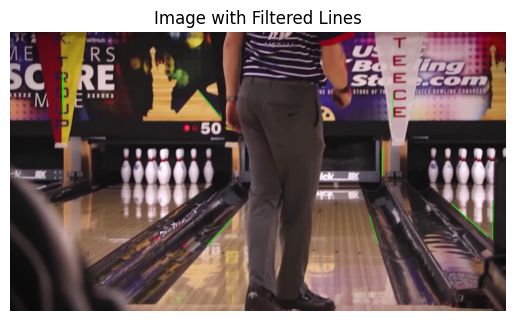

In [13]:
# Get the y-size of the image
y_size = image_color.shape[0]

# Calculate the y-coordinate threshold for the bottom fifth of the image
y_threshold = 4 * y_size // 5

# Filter out lines that are 'quite horizontal' with a tolerance of 20 degrees
# and are in the bottom quarter of the image
filtered_lines = []
tolerance = 20
for line in non_horizontal_lines:
    x1, y1, x2, y2 = line[0]
    angle = calculate_angle(x1, y1, x2, y2)
    if angle < (-tolerance) or angle > (+tolerance):
        if y1 < y_threshold and y2 < y_threshold:
            filtered_lines.append(line)

# Draw the filtered lines on the image
image_with_filtered_lines = np.copy(image_color)
for line in filtered_lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(image_with_filtered_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Show the image with filtered lines
plt.imshow(cv2.cvtColor(image_with_filtered_lines, cv2.COLOR_BGR2RGB))
plt.title("Image with Filtered Lines")
plt.axis('off')
plt.show()

Trovo la linea più vicina al mio punto

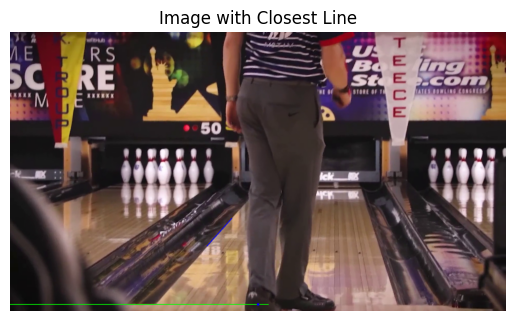

In [14]:
# Function to calculate the distance from a point to a line
def distance_point_to_line(x0, y0, x1, y1, x2, y2):
    return abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1) / math.sqrt((y2 - y1)**2 + (x2 - x1)**2)

# Initialize the minimum distance and the closest line
min_distance = float('inf')
closest_line = None

# Iterate through the filtered lines to find the closest one
for line in filtered_lines:
    x1, y1, x2, y2 = line[0]
    distance = distance_point_to_line(x_half, y_half, x1, y1, x2, y2)
    if distance < min_distance:
        min_distance = distance
        closest_line = line

# Draw the closest line on the image
image_with_closest_line = image_with_point.copy()
if closest_line is not None:
    x1, y1, x2, y2 = closest_line[0]
    cv2.line(image_with_closest_line, (x1, y1), (x2, y2), (255, 0, 0), 2)

# Show the image with the closest line
plt.imshow(cv2.cvtColor(image_with_closest_line, cv2.COLOR_BGR2RGB))
plt.title("Image with Closest Line")
plt.axis('off')
plt.show()

Trovo le linee con slope simile a quella trovata

In [13]:
# QUESTO USAVA UN ALTRA FUNZIONE, QUANDO ABBIAMO calculate_angle DISPONIBILE

# # Function to calculate the slope of a line
# def calculate_slope(x1, y1, x2, y2):
#     return math.degrees(math.atan2(y2 - y1, x2 - x1))

# # Calculate the slope of the closest line
# x1_closest, y1_closest, x2_closest, y2_closest = closest_line[0]
# slope_closest = calculate_slope(x1_closest, y1_closest, x2_closest, y2_closest)

# # Filter lines based on slope similarity with a tolerance of 30 degrees
# tolerance_slope = 30
# similar_slope_lines = []
# for line in filtered_lines:
#     x1, y1, x2, y2 = line[0]
#     slope = calculate_slope(x1, y1, x2, y2)
#     if abs(slope - slope_closest) <= tolerance_slope:
#         similar_slope_lines.append(line)

# # Draw the filtered lines on the image
# image_with_similar_slope_lines = np.copy(image_color)
# for line in similar_slope_lines:
#     x1, y1, x2, y2 = line[0]
#     cv2.line(image_with_similar_slope_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)

# # Show the image with filtered lines
# plt.imshow(cv2.cvtColor(image_with_similar_slope_lines, cv2.COLOR_BGR2RGB))
# plt.title("Image with Similar Slope Lines")
# plt.axis('off')
# plt.show()

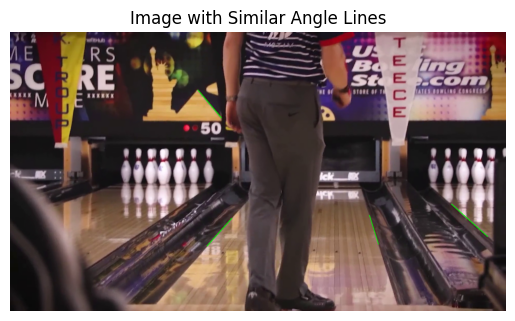

In [18]:
# Calculate the angle of the closest line
x1_closest, y1_closest, x2_closest, y2_closest = closest_line[0]
angle_closest = calculate_angle(x1_closest, y1_closest, x2_closest, y2_closest)

# Filter lines based on angle similarity with a tolerance of 30 degrees
tolerance_angle = 30
similar_angle_lines = []
for line in filtered_lines:
    x1, y1, x2, y2 = line[0]
    angle = calculate_angle(x1, y1, x2, y2)
    if abs(angle - angle_closest) <= tolerance_angle:
        similar_angle_lines.append(line)

# Draw the filtered lines on the image
image_with_similar_angle_lines = np.copy(image_color)
for line in similar_angle_lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(image_with_similar_angle_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Show the image with filtered lines
plt.imshow(cv2.cvtColor(image_with_similar_angle_lines, cv2.COLOR_BGR2RGB))
plt.title("Image with Similar Angle Lines")
plt.axis('off')
plt.show()

Tra le linee trovate, trovo le 2 più vicine al punto

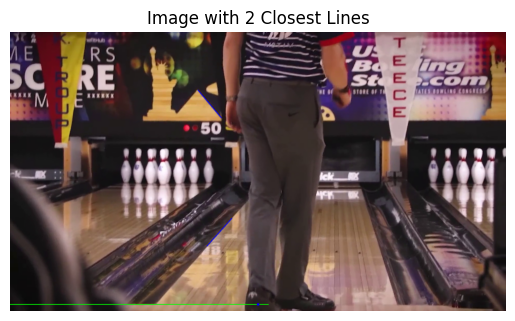

In [16]:
# Calculate the distances from the point to each line
distances = []
for line in filtered_lines:
    x1, y1, x2, y2 = line[0]
    distance = distance_point_to_line(x_half, y_half, x1, y1, x2, y2)
    distances.append((distance, line))

# Sort the lines based on the distance
distances.sort(key=lambda x: x[0])

# Select the 2 closest lines
closest_lines = [distances[0][1], distances[1][1]]

# Draw the 2 closest lines on the image
image_with_closest_lines = image_with_point.copy()
for line in closest_lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(image_with_closest_lines, (x1, y1), (x2, y2), (255, 0, 0), 2)

# Show the image with the 2 closest lines
plt.imshow(cv2.cvtColor(image_with_closest_lines, cv2.COLOR_BGR2RGB))
plt.title("Image with 2 Closest Lines")
plt.axis('off')
plt.show()

Uniscco in vari pezzi per copiarlo nell'altro file

In [16]:
'''FUNZIONI UTILIZZATE'''
# Function to calculate the angle of a line
def calculate_angle(x1, y1, x2, y2):
    return abs(math.degrees(math.atan2(y2 - y1, x2 - x1)))

# Function to calculate the distance from a point to a line
def distance_point_to_line(x0, y0, x1, y1, x2, y2):
    return abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1) / math.sqrt((y2 - y1)**2 + (x2 - x1)**2)

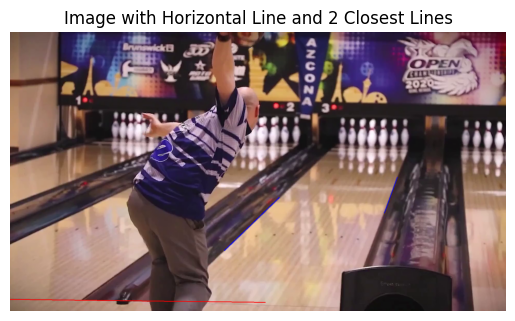

In [17]:
# define the horizontal line
horizontal_line = [rho, theta]  

# COMPUTE THE MIDDLE POINT OF THE HORIZONTAL LINE
# Get the x-size of the image
x_size = image_color.shape[1]

# Calculate the x-coordinate that is half of the x-size
x_half = x_size // 2

# Calculate the corresponding y-coordinate using the line equation
y_half = int((rho - x_half * a) / b)

point_half = [x_half, y_half]

# edges e lines_p già calcolati

# ELIMINATE THE 'QUITE HORIZONTAL' LINES
# Filter out lines that are 'quite horizontal' with a tolerance of 20 degrees
non_horizontal_lines = []
tolerance = 20
for line in lines_p:
    x1, y1, x2, y2 = line[0]
    angle = calculate_angle(x1, y1, x2, y2) 
    if angle < ( - tolerance) or angle > ( + tolerance):
        non_horizontal_lines.append(line)

# ELIMINATE THE LINES IN THE LAST FIFTH OF THE IMAGE
# Get the y-size of the image
y_size = image_color.shape[0]

# Calculate the y-coordinate threshold for the bottom fifth of the image
y_threshold = 4 * y_size // 5

# Filter out lines that are 'quite horizontal' with a tolerance of 20 degrees
# and are in the bottom quarter of the image
filtered_lines = []
tolerance = 20
for line in non_horizontal_lines:
    x1, y1, x2, y2 = line[0]
    if y1 < y_threshold and y2 < y_threshold:
            filtered_lines.append(line)

# FIND THE CLOSEST LINE TO THE MIDDLE POINT OF THE HORIZONTAL LINE


# Initialize the minimum distance and the closest line
min_distance = float('inf')
closest_line = None

# Iterate through the filtered lines to find the closest one
for line in filtered_lines:
    x1, y1, x2, y2 = line[0]
    distance = distance_point_to_line(x_half, y_half, x1, y1, x2, y2)
    if distance < min_distance:
        min_distance = distance
        closest_line = line

# FIND THE LINES WITH SIMILAR SLOPE TO THE CLOSEST LINE
# Calculate the angle of the closest line
x1_closest, y1_closest, x2_closest, y2_closest = closest_line[0]
angle_closest = calculate_angle(x1_closest, y1_closest, x2_closest, y2_closest)

# Filter lines based on angle similarity with a tolerance of 30 degrees
tolerance_angle = 30
similar_angle_lines = []
for line in filtered_lines:
    x1, y1, x2, y2 = line[0]
    angle = calculate_angle(x1, y1, x2, y2)
    if abs(angle - angle_closest) <= tolerance_angle:
        similar_angle_lines.append(line)

# FIND THE TWO CLOSEST LINES TO THE MIDDLE POINT OF THE HORIZONTAL LINE
# Calculate the distances from the point to each line
distances = []
for line in filtered_lines:
    x1, y1, x2, y2 = line[0]
    distance = distance_point_to_line(x_half, y_half, x1, y1, x2, y2)
    distances.append((distance, line))

# Sort the lines based on the distance
distances.sort(key=lambda x: x[0])

# Select the 2 closest lines
closest_lines = [distances[0][1], distances[1][1]]

# Draw the horizontal line and the 2 closest lines on the image
image_with_all_lines = image_color.copy()

# Draw the horizontal line
rho, theta = horizontal_line
a = np.cos(theta)
b = np.sin(theta)
x0 = a * rho
y0 = b * rho
pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))
cv2.line(image_with_all_lines, pt1, pt2, (0, 0, 255), 2)

# Draw the 2 closest lines
for line in closest_lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(image_with_all_lines, (x1, y1), (x2, y2), (255, 0, 0), 2)

# Show the image with the horizontal line and the 2 closest lines
plt.imshow(cv2.cvtColor(image_with_all_lines, cv2.COLOR_BGR2RGB))
plt.title("Image with Horizontal Line and 2 Closest Lines")
plt.axis('off')
plt.show()

Save the detected lines

In [18]:
# Define the path to save the CSV file
output_path = project_root / "data" / "auxiliary_data" / "lane_lines" / "lines_3.csv"
output_path = str(output_path)

# Prepare the data for saving
lines_data = [
    {"type": "horizontal", "x1": pt1[0], "y1": pt1[1], "x2": pt2[0], "y2": pt2[1]},
    {"type": "closest_1", "x1": closest_lines[0][0][0], "y1": closest_lines[0][0][1], "x2": closest_lines[0][0][2], "y2": closest_lines[0][0][3]},
    {"type": "closest_2", "x1": closest_lines[1][0][0], "y1": closest_lines[1][0][1], "x2": closest_lines[1][0][2], "y2": closest_lines[1][0][3]},
]

# Convert the data to a DataFrame
lines_df = pd.DataFrame(lines_data)

# Save the DataFrame to a CSV file
lines_df.to_csv(output_path, index=False)

print(f"Lines saved to {output_path}")

Lines saved to C:\Users\miche\OneDrive\Documenti\GitHub\bowling-analysis\data\auxiliary_data\lane_lines\lines_3.csv
